In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
from sklearn.decomposition import PCA
from PIL import Image

## 1. Cargar el Corpus (Imágenes)

En este primer paso, trabajaremos con el **conjunto de datos de caras de Olivetti**, un clásico en tareas de reconocimiento facial.  
Este dataset contiene imágenes de rostros en escala de grises, organizadas para permitir pruebas con algoritmos de reducción de dimensionalidad y reconocimiento de patrones.  

El objetivo de este paso es **cargar el conjunto de imágenes** en memoria para poder procesarlo posteriormente con PCA.  
Nos aseguraremos de que las imágenes se encuentren en el formato adecuado (matriz de píxeles) y que podamos acceder a sus etiquetas (identidad de cada persona).


In [2]:
dataset = fetch_olivetti_faces(shuffle=True, random_state=42)

## 2. Datos originales
  
Las imágenes de \(64 x 64\) píxeles no se guardan como matrices 2D, sino como vectores unidimensionales, es decir, cada imagen está “aplanada” en una sola fila con \(h x w\) valores.

Cada imagen cuenta con una **etiqueta** que identifica a la persona correspondiente.  

In [3]:
h, w = 64, 64 # dimensiones originales
images = dataset.data # imágenes
labels = dataset.target # etiquetas
n_samples, n_features = images.shape
print(f"Hay {n_samples} imágenes.")

Hay 400 imágenes.


## 3. Visualizar una imagen

Vamos a ver que pinta tiene la primera imagen del corpus.

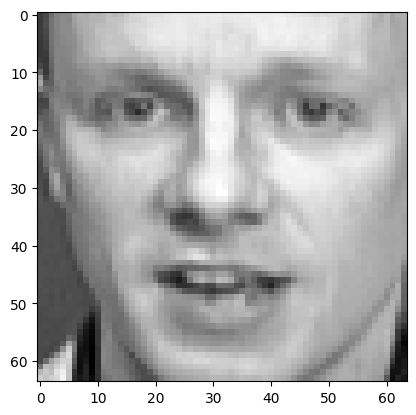

In [4]:
imagen = images[0].reshape((h, w))

plt.imshow(imagen, cmap='gray')
plt.show()

## 4. Visualizar el vector de una imagen

Vamos a ver como se representa esa imagen en el corpus.

In [5]:
print(images[0])

[0.1983471  0.23553719 0.35123968 ... 0.06198347 0.12809917 0.09090909]


## 5. Seleccionar el número de componentes principales (k)

En PCA, debemos decidir cuántos **componentes principales** queremos conservar. En este caso vamos a elegir 2 para poder mostrar el resultado.


In [6]:
n_components = 2

## 6. Crear y ajustar el modelo PCA

Para aplicar Análisis de Componentes Principales, primero creamos un **objeto PCA** indicando el número de componentes (`n_components`) que queremos conservar.  

El procedimiento habitual es:

1. **`fit()`**: Calcula los **componentes principales** (vectores propios) y sus varianzas (valores propios) a partir de los datos originales.
2. **`transform()`**: Proyecta los datos originales en el nuevo subespacio definido por los componentes principales.


El parámetro `whiten=True` es para normalizar la varianza.


In [7]:
pca = PCA(n_components=n_components, svd_solver='auto', whiten=True)

pca.fit(images)

imagen_reducida = pca.transform(images)

print(f"Forma original de los datos: {images.shape}")
print(f"Forma reducida de los datos: {imagen_reducida.shape}")

Forma original de los datos: (400, 4096)
Forma reducida de los datos: (400, 2)


## 7. Cuánta varianza (información) hemos conservado

Una de las métricas clave en PCA es la **varianza explicada** por cada componente principal (en el ejemplo solo 2 componentes).
  
Esta medida nos indica qué proporción de la información original (varianza total) está siendo retenida tras la reducción dimensional.

- `explained_variance_ratio_` es un array que contiene la fracción de varianza explicada por cada componente principal.
- La suma de estos valores para los primeros `k` componentes nos da la **varianza total conservada** en el nuevo espacio reducido.

Esto nos permite saber si el número de componentes seleccionados es suficiente o si debemos ajustar `k` para preservar más información.


In [8]:
print(f"Varianza explicada por cada componente: {pca.explained_variance_ratio_}")
print(f"Varianza total explicada por los {n_components} componentes: {pca.explained_variance_ratio_.sum():.4f}")

Varianza explicada por cada componente: [0.23812702 0.13993964]
Varianza total explicada por los 2 componentes: 0.3781


## 8. Visualización de la proyección en 2D

Como hemos reducido a **2 componentes principales**, podemos visualizar las imágenes proyectadas como puntos en un espacio 2D.



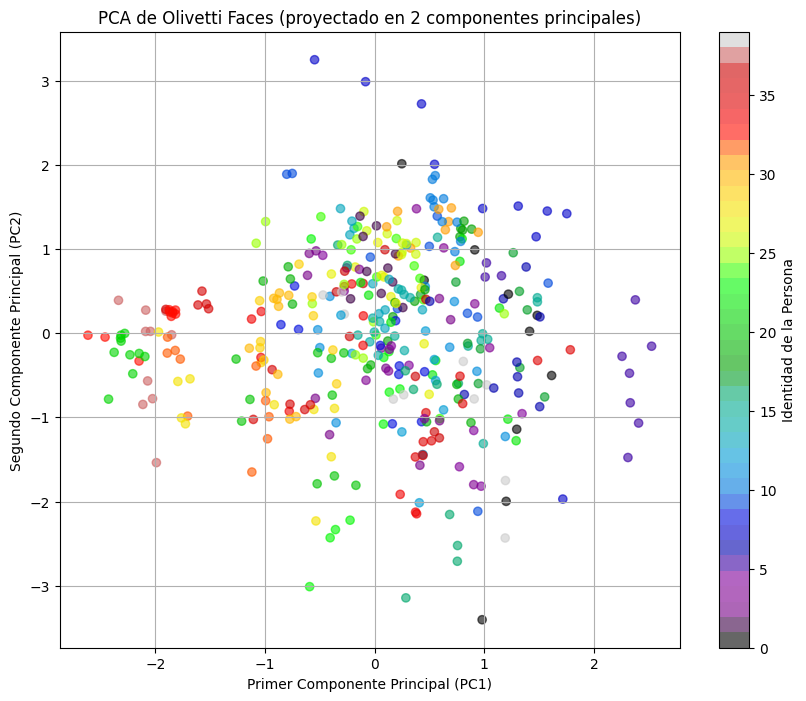

In [9]:
if n_components == 2:
    plt.figure(figsize=(10, 8))
    cmap = plt.get_cmap('nipy_spectral', len(np.unique(labels)))
    scatter = plt.scatter(imagen_reducida[:, 0], imagen_reducida[:, 1], c=labels, cmap=cmap, alpha=.6)

    plt.title('PCA de Olivetti Faces (proyectado en 2 componentes principales)')
    plt.xlabel('Primer Componente Principal (PC1)')
    plt.ylabel('Segundo Componente Principal (PC2)')
    plt.colorbar(scatter, label='Identidad de la Persona')
    plt.grid(True)
    plt.show()

## 9. Visualización de los Componentes Principales

Los componentes principales obtenidos por PCA pueden interpretarse como **“eigenfaces”**, es decir, imágenes que representan patrones básicos o rasgos característicos de los rostros del conjunto de datos.  

Veamos que pinta tienen.


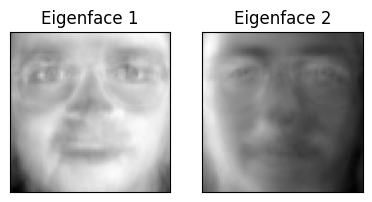

In [10]:
eigenfaces = pca.components_.reshape((n_components, h, w))

def plot_gallery(images, titles, h, w, n_row=1, n_col=n_components):
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.95, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i], cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

eigenface_titles = [f"Eigenface {i+1}" for i in range(n_components)]
plot_gallery(eigenfaces, eigenface_titles, h, w)
plt.show()


## 10. Elegir \(k\) basándose en la varianza explicada

Hasta ahora hemos usado solo 2 componentes principales. Pero, ¿cómo sabemos cántos hacen falta? Para determinar cuántos componentes principales conservar, podemos calcular PCA con el máximo número posible de componentes (usando `n_components=None`) y analizar la **varianza acumulada explicada**.  

Lo normal es elegir un valor de \(k\) que asegure que, por ejemplo, el **95% de la varianza** sea preservada, garantizando así que la reducción dimensional no pierda información importante.


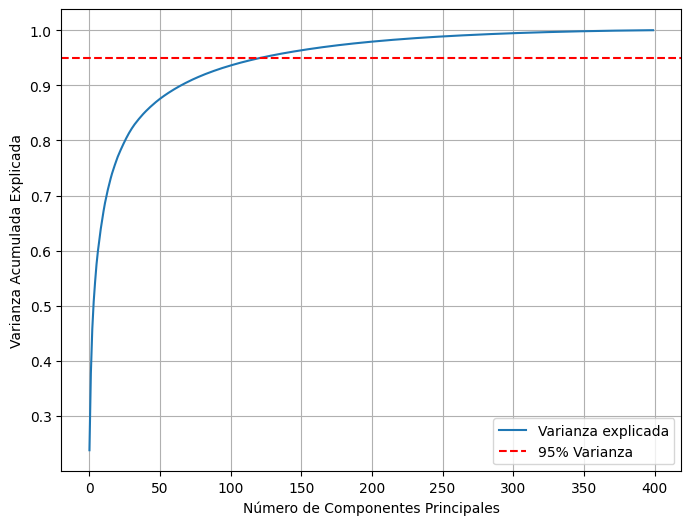

In [11]:
pca_full = PCA(n_components=None, svd_solver='auto')
pca_full.fit(images)

plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_),label='Varianza explicada')
plt.xlabel('Número de Componentes Principales')
plt.ylabel('Varianza Acumulada Explicada')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Varianza')
plt.legend()
plt.show()

## 11. Número de componentes necesarios para explicar el 95% de la varianza

Después de calcular la varianza acumulada explicada, podemos determinar exactamente cuántos componentes principales son necesarios para conservar al menos el **95% de la información original**.

Este valor nos indica la **dimensionalidad mínima** en la que podemos representar los datos sin perder demasiada información.  


In [12]:
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Se necesitan {n_components_95} componentes para explicar el 95% de la varianza.")
print(f"(Comparado con la dimensión original de {n_features})")

Se necesitan 123 componentes para explicar el 95% de la varianza.
(Comparado con la dimensión original de 4096)


## 12. Prueba con tu propia imagen



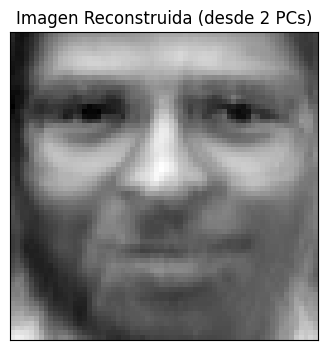

In [23]:
# Reemplaza 'imagen.png' con el nombre de la imagen
ruta = 'domingo.png'

try:
    # Cargar la imagen y convertirla a escala de grises
    imagen = Image.open(ruta).convert('L')
    # Redimensionar la imagen (64x64)
    imagen = imagen.resize((w, h))
    # Aplanarla
    imagen = np.array(imagen).flatten()
    # Normalizar
    imagen = imagen / 255.0
    imagen = imagen.reshape(1, -1)

    # Proyectar la imagen al subespacio
    imagen = pca.transform(imagen)

    # Ahora la reconstruimos
    my_image_reconstructed = pca.inverse_transform(imagen)
    my_image_reconstructed_reshaped = my_image_reconstructed.reshape(h, w)
    my_image_reconstructed_reshaped = np.clip(my_image_reconstructed_reshaped * 255, 0, 255).astype(np.uint8)


    plt.figure(figsize=(8, 4))
    plt.imshow(my_image_reconstructed_reshaped, cmap=plt.cm.gray)
    plt.title(f'Imagen Reconstruida (desde {n_components} PCs)')
    plt.xticks(())
    plt.yticks(())
    plt.show()

except Exception as e:
    print(f"{e}")

## Ejercicio 1

Prueba con diversos números de componentes y analiza lo que sucede con la imagen reconstruida.

## Ejercicio 2

Modifica el paso 12 para observar lo que sucede al pasarle la primera imagen del corpus mostrada en el paso 3. Prueba lo que sucede con diferente número de componentes.

## Ejercicio 3

¿Qué sucede cuando la imagen no contiene una cara?